# CISC873 F20 Assignment 0
## Katy Scott - 15kls3 - 20009328

*Note: must upload train.csv and test.csv manually before running*

In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Functions 🔢

For the preprocessing step, things I found to be lengthy to write twice for training and testing I made into functions for readability.

In [6]:
def impute_and_encode_category(df, feature):
# Function to impute a string feature with it's most common value, convert it
# to a category, and encode it as integers.
# INPUT:     df - pandas dataframe, dataframe with feature to be processed
#       feature - string, column name of feature to be processed
# OUTPUT:    df - pandas dataframe with feature imputed and encoded to int

# 2020-10-01 Updated to be simpler, imputation can be done in one line

  # Imputes using mode of feature
  df[feature] = df[feature].fillna(df[feature].mode()[0])

  # Convert to categorical type
  df[feature] = df[feature].astype('category')

  # Encode the categories as int8
  df[feature] = df[feature].cat.codes

  return df

In [7]:
def scale_standard_return_df(df, cols_to_scale=[]):
# Function that scales data with Standard Scaler and returns the scaled data 
# frame. Can scale all data in a dataframe or specified columns.
# INPUT:           df - pandas df, dataframe to be scaled
#       cols_to_scale - list of strings, column names to be scaled
# OUTPUT:   scaled_df - df with all columns scaled (if cols_to_scale is empty)
#                  df - df with specified columns scaled

# 2020-10-02 Updated to handle scaling all data or just some columns

  # Initialize scaler
  scaler = StandardScaler()
  
  if not cols_to_scale:
    # Scaling all the data
    # Scale data in dataframe, creates an array
    scaled_arr = scaler.fit_transform(df)
    # Get column names from dataframe input
    column_names = df.columns
    # Convert back scaled data back to dataframe
    scaled_df = pd.DataFrame(scaled_arr, columns=column_names)
    
    return scaled_df

  else:
    # Scale specified columns
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    return df

# Data Loading and Setup 📤

Here I load in the train and test sets from the provided csv files. 
I extract the ID and rating columns from the training set, and convert both to data frames. I also convert the rating to a numpy array for the modelling section.

## Training Set

In [2]:
# Set up the training set
train_set = pd.read_csv('train_new.csv')

# Take out rating column and make it's own dataframe
col_rating = train_set['rating']
df_rating = col_rating.to_frame()

# Remove ID from training
train_noID = train_set.drop(columns=['id'])

# Remove rating column 
train = train_noID.drop(columns=['rating'])

## Testing Set

In [3]:
# Set up the testing set
test_set = pd.read_csv('test_new.csv')

# Take out ID 
test_ID = test_set['id'].to_numpy()
test = test_set.drop(columns=['id'])

# Data Exploration 🗺

🔍 Started with studying the correlation heat map and noted the features that had any correlation with rating as well as any combinations with correlation greater than 0.5

🔍 Used this list to begin deciding which attributes could be removed during preprocessing. 

🔍 Noticed that the heat map was missing some of the features

🔍 Switched to examining the data in Microsoft Excel so I could get a sense of the different data types and see if any of the non-numeric features were worth further investigation. 

🔍 Began a list of features that I planned to remove:
> 🔎 String features that would not easily convert to categories (ex. tags)

> 🔎 Redundant features that could be represented by another feature (ex. Urgency text)

> 🔎 Features that had no relation to the rating (ex. crawl month). 

🔍 Once I had narrowed down my feature selection, I began looking for features with missing or NaN values. 
> 🔎 Found origin_country and has_urgency_banner

> 🔎 Need to fill these in.

🔍 I moved onto preprocessing at this point, but ended up coming back to look at the distributions of the features when I was trying to figure out scaling





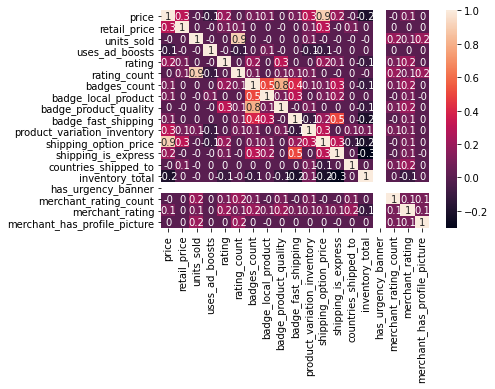

In [8]:
# Correlation heat map between all numeric attributes
sns.heatmap(data=train_noID.corr().round(1), annot=True)

In [ ]:
# Calculating correlation between rating and other attributes
train.corrwith(col_rating)

In [ ]:
# Checking if features have any missing values (manually replacing attribute)
train_set['merchant_rating'].isnull().any()

In [ ]:
# Looking at distribution of features
sns.distplot(train['price'])

# Data Preprocessing 🗂
For all my preprocessing techniques, I do some preliminary data cleaning 🛁.

❌ Remove single rating outlier before any preprocessing.

In [9]:
# Removing outlier rating
# Find index of outlier  rating
outlier_index = df_rating[df_rating['rating'] > 5].index[0]

# Drop that index from the ratings dataframe
df_rating.drop(outlier_index, inplace=True)
arr_rating = df_rating['rating'].to_numpy()

# Drop that index from the features dataframe
train.drop(outlier_index, inplace=True)


❌ Remove the features I had chosen in the exploration 🗺 stage.

In [10]:
# Removing redundant/unneeded columns
redundant_attr = ['tags', 'urgency_text', 'merchant_title', 'merchant_name', 
                  'merchant_has_profile_picture', 'merchant_profile_picture',
                  'merchant_info_subtitle', 'merchant_id', 'theme', 
                  'crawl_month', 'product_color', 'product_variation_size_id', 
                  'product_variation_inventory', 'shipping_option_name',
                  'currency_buyer']
train_noRed = train.drop(columns=redundant_attr)
test_noRed = test.drop(columns=redundant_attr)

🔘 Filled in the missing or NaN values for origin_country and has_urgency_banner
*  Used the most frequent value for origin_country because I planned to categorize it so using an average wouldn’t make sense
*  Has_urgency_banner is Boolean feature and the missing values are all false so I filled them in as zeros

In [11]:
# Filling in NaN values
# Clean origin country by replacing NaN with most frequent value
train_cleaning = impute_and_encode_category(train_noRed, 'origin_country')
test_cleaning = impute_and_encode_category(test_noRed, 'origin_country')

# Clean has_urgency_banner by replacing NaN with 0s
train_cleaned = train_cleaning.fillna({"has_urgency_banner": 0})
test_cleaned = test_cleaning.fillna({"has_urgency_banner": 0})

#Technique 0️⃣
Tried with no scaling - just used train_cleaned and test_cleaned

## Technique 1️⃣ - Scaling all data
For my first technique, I chose to scale all the data regardless of data type. I used the scikit learn Standard Scaler in a function I made.

At this point, I was choosing simple preprocessing as I wanted to get through the modelling stage and have one version of my script complete.
The results I got using this technique were better than I expected for a first choice. 

In [12]:
# Scaling all data
train_scaled = scale_standard_return_df(train_cleaned)
test_scaled = scale_standard_return_df(test_cleaned)

## Technique 2️⃣ - Scaling some of the data
Once I had figured out my modelling, training, validation, and testing process, I went back to look at other preprocessing techniques. When I was reviewing my data, I realized that I had been scaling categorical and boolean features. So in this second technique, the only change I made was to exclude those and only scale the remaining numeric attributes. I chose to scale all the numeric attributes after examining their distributions again in the data exploration stage and found that they were all skewed in some way.

This improved the results I got from technique 1.

In [13]:
# Scaling some data
# Attributes to NOT scale: uses_ad_boosts, badges_count, badge_local_product, 
#                          badge_product_quality, badge_fast_shipping, 
#                          has_urgency_banner, origin_country
cols_to_scale = ['price', 'retail_price', 'units_sold', 'rating_count', 
                 'countries_shipped_to', 'inventory_total', 
                 'merchant_rating_count', 'merchant_rating']
train_some_scaled = scale_standard_return_df(train_cleaned, cols_to_scale)
test_some_scaled = scale_standard_return_df(test_cleaned, cols_to_scale)

## Technique 3️⃣ - Correlation based feature selection
Lastly I decided to explore what would happen if I pruned my data further based on correlations. 

In [14]:
# Correlation analysis
# Removing more based on correlation
# Get series of booleans if absolute correlation with rating is greater than 0.1
train_highcorr_cols = train_some_scaled.corrwith(col_rating).abs() > 0.1
# Get columns with high correlation in a numpy array
arr_highcorr_cols = train_highcorr_cols[train_highcorr_cols].index.values
# Drop columns that don't have high enough correlation
train_highcorr = train_some_scaled.drop(
                columns=train_some_scaled.columns.difference(arr_highcorr_cols))
test_highcorr = test_some_scaled.drop(
                 columns=test_some_scaled.columns.difference(arr_highcorr_cols))

#Problem Formulation ➕➖➗✖️
💁🏻‍♀️ **Define the problem:** Goal is to predict product ratings given other features known for a product on Wish.com

💁🏻‍♀️ **Input**: Data with unknown rating levels and other features known about them

💁🏻‍♀️ **Output**: Prediction of rating level

💁🏻‍♀️ **What data mining function is required?:** Classification

💁🏻‍♀️ **What could be the challenges?:**

*   Outliers/noisy data skewing results
*   Lots of models to choose from
*   Lots of parameters to tune on those models



# Model Creation and Tuning 🎛

Short version of what I did: 

🎚 Started with default arguments

🎚 Tried raising and lowering the defaults

🎚 Found out that defaults worked better than anything I could come up with (with one exception)

🎚 Most of the time my tuning ended up overfitting the model

*Note: The models in the code are the 5 variants I submitted to kaggle.*

##🥅 Neural Network - Multi-layer Perceptron Classifier 🥅



🧠 Chose this as my first model because I've worked with neural networks before

🧠 Started with all default arguments to get a baseline

🧠 Immediately got convergence warnings, so increased the max_iter argument until that went away
* Default = 200
* Tried 500, 1000, 5000

🧠 Once I had no more convergence warning, worked through some other arguments by trying values above and below the default to see what would happen.
> 🧠 alpha
* Default = 0.0001
*  0.001 - had higher train score, but lower test score
*  0.00001 - raised train score but lowered test score

> Thought that lower alpha meant it would take longer to train, so tried raising the number of iterations.

>*  0.00001 with more iterations 7000/10000 - improved train but not test
* revert back to 5000

> 🧠 hidden_layer_sizes
* Default = (100,)
* (100,5) - same result as with alpha tuning, get higher train but lower test
* (100, 100, 5) - training got really good, test got even worse
* (50,) - maybe going the other direction will help? → train is better than default but not as good as other tuning, but testing is almost at 70s
* (50,50) - try adding another layer of the same size, might overfit again → Did exactly that
* (50,5) - try a smaller second layer → brought training down a little, test still in low 60s
* (20, 7, 5, 1) - got these numbers from an old classification problem I practiced on → brought train back down closer to test, test almost breaking 70
* (20, 7, 5) - improved train to mid 80s, test still 60s

> Decided to try tuning alpha along with these smaller layer sizes to see if it would make a difference.
* (20, 7, 5) w/ alpha=0.001 - improved train score and test score slightly, now high 60s
* (10, 7, 5) - good

> Then decided to reduce iterations again since I reduced alpha
* (10, 7, 5) w/ 2500 + alpha=0.001 iterations - good
* (10, 7, 5) w/ 5000 + alpha=0.0001 - better
* (10, 7, 5, 1) - good too

> 🧠 Solver
* Default = adam
* Tried sgd so I could use momentum
* sgd ran slower than adam

> 🧠 Momentum
* Default = 0.9
* 0.7 - worsened results 
* 0.95 - slightly better variance
* 0.98 - very slow



In [ ]:
# MLP CLASSIFIER MODELS
# Model 1 - MLP Classifier with defaults
model = MLPClassifier()

# Model 2
# model = MLPClassifier(max_iter=5000)

# Model 3
# model = MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=5000)

# Model 4
# model = MLPClassifier(hidden_layer_sizes=(150,), solver='sgd', max_iter=5000 )

# Model 5
# model = MLPClassifier(hidden_layer_sizes=(150,), solver='sgd', 
#                       max_iter=5000, momentum=0.95)

##🚜 Support Vector Machine - Support Vector Classifier 🚜

🏗 I'm not as familiar with SVM

🏗 Looked for a tutorial and found this one: https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02)

🏗 Tutorial showed four kernel functions so decided to start with those four as my variants

🏗 Started with the default for all parameters
* Changed the decision function shape from one-versus-rest to one-versus-one, but got the same result

🏗 Linear kernel
* I predicted that this would be the worst one
* Ended up getting about the same score as the default MLP Classifier

🏗 RBF kernel
* Default kernel for SVC
* Tried to tune the gamma parameter

🏗 Polynomial kernel
* Ended up being the best of the four
* Spent more time trying to tune this model
* Adjusted degree
** Tried 2, 3, and 4
** 3 ended up returning the best results
** 4 overfit the model, as expected
* Tried adjusting C 
** Lowering C any further than 0.8 had negative results
** Raised C to 2 but ended up overfitting model

🏗 Sigmoid kernel
* Only tried the default
* Validation results were the worst of this bunch 
* Chose not to submit to Kaggle, chose to submit second polynomial model instead




In [ ]:
# SVC models
# Model 1
model = svm.SVC()

# Trying different kernel functions
# Model 2 - Linear kernel
# model = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo')

# Model 3 - RBF kernel with gamma
# model = svm.SVC(kernel='rbf', gamma=2, C=1, decision_function_shape='ovo')

# Model 4 - Polynomial
# model = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo')

# Model 5 - Polynomial with C=2
# model = svm.SVC(kernel='poly', degree=3, C=2, decision_function_shape='ovo')

##🌲 Random Forest Classifier 🌲

🎲 I chose this model out of the tutorial posted on Kaggle
(https://stackabuse.com/classification-in-python-with-scikit-learn-and-pandas/)

🎲 As with other two models, began with default

🎲 Achieved highest validation scores I'd seen so far

🎲 As with the MLP models, worked through some other arguments by trying values above and below the default to see what would happen

🎲 n_estimators
*  Used 10, 50, 500, and 1000
*  Made very little difference to score
*  All gave validation results of ~80 for F1 score
*  Submitting to Kaggle with 1000 gave better score than default value of 100, so stuck with that

🎲 Bootstrap
* Saw that bootstrapping was on by default, wanted to see what using the whole dataset would do
* My prediction was it would be worse, mostly because the default got such a good score using it
* Submitting to Kaggle showed that it did better than the default with 100 n_estimators, but worse than 1000 n_estimators

🎲 max_depth
* Thought this would have a visible impact on the result
* Predicted that setting this to a low value would make the scores worse since the tree would be limited
* Didn't know how big the tree was getting by default though
* max_depth = 10 → lowered training score but had little impact on the testing score in validation
* max_depth = 20 and 50 → same results as default settings

🎲 criterion
* We had discussed entropy in class, so I wanted to try it here
* Achieved the same validations here and on Kaggle
* Got the smalled standard deviation in the testing validation

🎲 Something I noted during all my parameter tuning for these models is that no matter what I changed, the standard deviation for the training validation was always small (< 0.001 mostly)


In [ ]:
# Random Forest models
# Model 1
model = RandomForestClassifier()
# Model 2
# model = RandomForestClassifier(n_estimators=1000)
# Model 3
# model = RandomForestClassifier(n_estimators=1000, bootstrap=False)
# Model 4
# model = RandomForestClassifier(n_estimators=500, criterion='entropy', 
#                                max_depth=50)
# Model 5 
# model = RandomForestClassifier(n_estimators=1000, max_depth=50)


## Validation 📋

✔️ I chose to use k-fold validation as my experimental protocol as it is a method I am familiar with. 

✔️ I remembered that an 80-20 split is common for train-test and it was also the default for the sklearn KFold class, so I went with a k value of 5.

✔️ Took the mean and standard deviation of the 5 train and test F1-scores

In [ ]:
# Choosing preprocessing mode for X
# Can be set as train_cleaned, train_scaled, train_some_scaled, 
# or train_highcorr
X = train_some_scaled
# Using ratings as labels
y = arr_rating

# Using k-fold cross validation experimental method
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
kf = KFold(n_splits = 5, shuffle = True)

# Lists to store train and test results from each fold
train_results = []
test_results = []

for ind_train, ind_test in kf.split(X, y):
  # Get training data for this fold
  train_X = X.iloc[ind_train]
  # Get training labels for this fold
  train_y = y[ind_train]

  # Get testing data for this fold
  test_X = X.iloc[ind_test]
  # Get testing labels for this fold
  test_y = y[ind_test]

  # Fit the model to the training data and labels
  fold_fit = model.fit(train_X, train_y)
  # Run prediction on training data
  fold_train_pred = fold_fit.predict(train_X)
  # Run prediction on testing data
  fold_test_pred = fold_fit.predict(test_X)

  # Calculate F1 Mean for training data
  # micro argument calculates metrics globally by counting the total true 
  # positives, false negatives and false positives.
  train_f1 = f1_score(train_y, fold_train_pred, average='micro')
  # Calculate F1 Mean for testing data
  # micro argument calculates metrics globally by counting the total true 
  # positives, false negatives and false positives.
  test_f1 = f1_score(test_y, fold_test_pred, average='micro')

  # Add f1 score to result lists
  train_results.append(train_f1)
  test_results.append(test_f1)

# Calculate average and standard deviation of training results across the 
# k validation runs
train_avg = np.round(np.average(train_results),4)
train_std = np.round(np.std(train_results),4)

# Calculate average and standard deviation of testing results across the 
# k validation runs
test_avg = np.round(np.average(test_results),4)
test_std = np.round(np.std(test_results),4)

# Printing results for study 
print("Train avg:", train_avg)
print("Train std:", train_std)

print("Test avg:", test_avg)
print("Test std:", test_std)

## Applying the Model 📈📉

In [ ]:
# Test set
# Can be set as test_cleaned, test_scaled, test_some_scaled, or test_highcorr
# Must match what was chosen for X
tX = test_some_scaled

# Fit model to entire training set
whole_NN = model.fit(X, y)
# Prediction on training set
train_pred = whole_NN.predict(X)

# Print out training result for entire training set to compare to validation
print("Total train:", f1_score(y, train_pred, average='micro'))

# Prediction on test set
test_pred = whole_NN.predict(tX)

# Output Test Results 💾

In [ ]:
# Reshaping prediction and ID from 1D to 2D numpy array
test_pred = np.reshape(test_pred, (test_pred.shape[0],1))
test_ID = np.reshape(test_ID, (test_ID.shape[0],1))
# Put prediction and ID into one numpy array
output_arr = np.concatenate((test_ID, test_pred), axis=1)

In [ ]:
# Save out the combined array as a csv with ID as an int and prediction as float 
# with one decimal place 
np.savetxt("15kls3_rfc5_p2.csv", output_arr, delimiter=",", fmt='%d,%.1f', 
           header='id,rating', comments='')

# Questions❓

**🌈 Why Data Mining is a misnomer? What is another preferred name?**
>Data mining is a misnomer because it focuses on the action of retrieving data rather than the extraction of knowledge or patterns that are interesting. Knowledge discovery in databases is a preferred alternative since it focuses more on the outcome.

**🌈 What is the general knowledge discovery process? What is the difference between a data engineer and data scientist/AI engineer?**
>The general knowledge discovery process starts with cleaning 🧹and integration of production data to be moved 🏗 into a separate data warehouse 🏭to be used for projects. Once a project has been planned and/or approved 👍, data relevant to the project is selected to be used for data mining ⚒. Data mining leads extracts interesting patterns from this subset of the data and leads to knowledge discovery 🧠🎉✅. Sometimes this knowledge is not exactly what we want, so it is possible to go back and reperform 🔄 some of these steps. For instance, we can tune 🎛 the hyperparameters in the data mining step or request more data 📊 in the selection process.

>Data engineers are involved in the collection and storing of data, while data scientist/AI engineers use that data for labelling, learning, and optimizing. This might involve statistical testing and/or building AI models.

**🌈 In data mining, what is the difference between prediction and categorization?**
>In data mining, prediction and categorization indicate what data type the target attribute is. Prediction is used when target attributes are numeric, and categorization is used for categorical.

**🌈 In a linear model, which regularization method encourages sparsity?**
>L-1 regularization encourages model sparsity.

**🌈 Why we need GD for optimization, rather than simply use linear algebra to solve a simple linear model?**
>Linear algebra is not scalable for a large dataset due to the polynomial complexity from the three matrix multiplications and the memory requirement to hold all the data at once. Gradient descent gradually improves the error rates instead of taking one shot at guessing the estimate. It still has polynomial complexity, but it’s assumed that the number of iterations to get to convergence is significantly lesser than the size of the data.

**🌈 In terms of bias and variance, defines what is overfitting and under fitting?**
>Underfitting occurs when bias is too high. Overfitting occurs when the variance is too high.

**🌈 Why data science/machine learning is a bad idea in the context of information security?**
>There are a number of threats to information when it is used for data science and machine learning, such as increased risks of data breaches and fines. It is also difficult to evaluate changes in AI since the training process can occur in a “black box” that humans cannot understand or explain. When developing AI for any purpose, responsibility has to be clearly delegated so if something does go wrong, someone is accountable for that.

